Project: stock price prediction of Alcoa Corp. stocks for next 3 days on the basis of previous 5 days data.

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'12GHNcSIeLoEGe-WLk37p6YDfI0om4GjH'}) 
downloaded.GetContentFile('aa.csv')

### Importing neccessary packages

In [ ]:
import numpy as np
#from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()

from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from sklearn.metrics import mean_squared_error , r2_score
import math

In [ ]:
import random

import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

### Loading the data

In [ ]:
stk_data= pd.read_csv('aa.csv')

In [ ]:
stk_data.shape


(4997, 6)

In [ ]:
stk_data

,Date,Open,High,Low,Close,Volume
0,1998-01-02,35.451,35.5730,35.098,35.392,1007509
1,1998-01-05,35.744,36.3070,35.702,36.000,2007164
2,1998-01-06,35.809,35.8090,35.159,35.202,1466149
3,1998-01-07,34.554,35.2670,34.554,35.267,1312312
4,1998-01-08,35.267,35.5130,33.700,33.764,941225
...,...,...,...,...,...,...
4992,2017-11-06,47.200,47.6800,46.530,47.290,1725638
4993,2017-11-07,47.110,47.2042,46.540,46.970,2168351
4994,2017-11-08,46.730,46.7700,45.370,45.890,3347930
4995,2017-11-09,44.710,44.7100,43.110,43.330,7671810


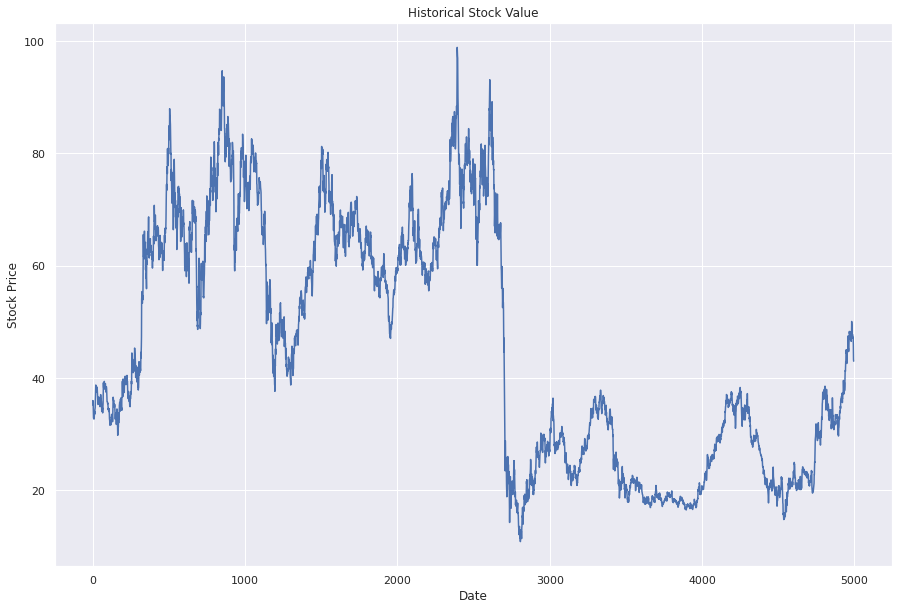

In [ ]:
# The profit or loss calculation is usually determined by the closing price of a stock for the day,
# hence we will consider the closing price as the target variable
plt.figure(figsize=(15,10))
plt.plot(stk_data['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


**Checking for NULL values in the dataset**

In [ ]:
stk_data.isnull().sum().sum()

0

### Normalizing the dataset

In [ ]:
scaler=MinMaxScaler(feature_range=(1,10))

In [ ]:
df_temp=stk_data[['Open','High','Low','Close','Volume']]
df_temp

,Open,High,Low,Close,Volume
0,35.451,35.5730,35.098,35.392,1007509
1,35.744,36.3070,35.702,36.000,2007164
2,35.809,35.8090,35.159,35.202,1466149
3,34.554,35.2670,34.554,35.267,1312312
4,35.267,35.5130,33.700,33.764,941225
...,...,...,...,...,...
4992,47.200,47.6800,46.530,47.290,1725638
4993,47.110,47.2042,46.540,46.970,2168351
4994,46.730,46.7700,45.370,45.890,3347930
4995,44.710,44.7100,43.110,43.330,7671810


In [ ]:
scaled_data = scaler.fit_transform(df_temp)

In [ ]:
scaled_data.shape

(4997, 5)

In [ ]:
scaled_data

array([[3.48492231, 3.3923331 , 3.56213004, 3.5059626 , 1.07819467],
       [3.51452757, 3.46554437, 3.62473225, 3.56816916, 1.15577978],
       [3.52109529, 3.41587242, 3.56845245, 3.48652305, 1.11379058],
       ...,
       [4.62457338, 4.50915418, 4.62678214, 4.58004888, 1.25983915],
       [4.42046883, 4.30368384, 4.39254209, 4.31812653, 1.59542362],
       [4.24061433, 4.27874812, 4.35522952, 4.28538623, 1.34644695]])

In [ ]:
new_df=pd.DataFrame(scaled_data, columns=['Open','High','Low','Close','Volume'])

In [ ]:
new_df.head()

,Open,High,Low,Close,Volume
0,3.484922,3.392333,3.562130,3.505963,1.078195
1,3.514528,3.465544,3.624732,3.568169,1.155780
2,3.521095,3.415872,3.568452,3.486523,1.113791
3,3.394288,3.361812,3.505747,3.493173,1.101851
4,3.466331,3.386349,3.417233,3.339396,1.073050


In [ ]:
#reseting the index of the new concatenated dataset
new_df=new_df.reset_index(drop=True)
new_df

,Open,High,Low,Close,Volume
0,3.484922,3.392333,3.562130,3.505963,1.078195
1,3.514528,3.465544,3.624732,3.568169,1.155780
2,3.521095,3.415872,3.568452,3.486523,1.113791
3,3.394288,3.361812,3.505747,3.493173,1.101851
4,3.466331,3.386349,3.417233,3.339396,1.073050
...,...,...,...,...,...
4992,4.672063,4.599920,4.747012,4.723288,1.133930
4993,4.662969,4.552463,4.748048,4.690547,1.168290
4994,4.624573,4.509154,4.626782,4.580049,1.259839
4995,4.420469,4.303684,4.392542,4.318127,1.595424


### date as index

In [ ]:
#datetime
date=stk_data.Date
date=pd.DataFrame(date.values, columns=['date'])
date

,date
0,1998-01-02
1,1998-01-05
2,1998-01-06
3,1998-01-07
4,1998-01-08
...,...
4992,2017-11-06
4993,2017-11-07
4994,2017-11-08
4995,2017-11-09


In [ ]:
df00=pd.concat([new_df, date], axis=1)
df00

,Open,High,Low,Close,Volume,date
0,3.484922,3.392333,3.562130,3.505963,1.078195,1998-01-02
1,3.514528,3.465544,3.624732,3.568169,1.155780,1998-01-05
2,3.521095,3.415872,3.568452,3.486523,1.113791,1998-01-06
3,3.394288,3.361812,3.505747,3.493173,1.101851,1998-01-07
4,3.466331,3.386349,3.417233,3.339396,1.073050,1998-01-08
...,...,...,...,...,...,...
4992,4.672063,4.599920,4.747012,4.723288,1.133930,2017-11-06
4993,4.662969,4.552463,4.748048,4.690547,1.168290,2017-11-07
4994,4.624573,4.509154,4.626782,4.580049,1.259839,2017-11-08
4995,4.420469,4.303684,4.392542,4.318127,1.595424,2017-11-09


In [ ]:
#setting datetim as an index and then removing it from the feature set.
df00['date']=pd.to_datetime(df00.date)
format='%Y-%m-%d'
df00['Datetime']=pd.to_datetime(df00['date'],format=format)
df00=df00.set_index(pd.DatetimeIndex(df00['Datetime']))
df00

,Open,High,Low,Close,Volume,date,Datetime
Datetime,,,,,,,
1998-01-02,3.484922,3.392333,3.562130,3.505963,1.078195,1998-01-02,1998-01-02
1998-01-05,3.514528,3.465544,3.624732,3.568169,1.155780,1998-01-05,1998-01-05
1998-01-06,3.521095,3.415872,3.568452,3.486523,1.113791,1998-01-06,1998-01-06
1998-01-07,3.394288,3.361812,3.505747,3.493173,1.101851,1998-01-07,1998-01-07
1998-01-08,3.466331,3.386349,3.417233,3.339396,1.073050,1998-01-08,1998-01-08
...,...,...,...,...,...,...,...
2017-11-06,4.672063,4.599920,4.747012,4.723288,1.133930,2017-11-06,2017-11-06
2017-11-07,4.662969,4.552463,4.748048,4.690547,1.168290,2017-11-07,2017-11-07
2017-11-08,4.624573,4.509154,4.626782,4.580049,1.259839,2017-11-08,2017-11-08


In [ ]:
df_raw=df00[['Open','High','Low','Close','Volume']]
df_raw

,Open,High,Low,Close,Volume
Datetime,,,,,
1998-01-02,3.484922,3.392333,3.562130,3.505963,1.078195
1998-01-05,3.514528,3.465544,3.624732,3.568169,1.155780
1998-01-06,3.521095,3.415872,3.568452,3.486523,1.113791
1998-01-07,3.394288,3.361812,3.505747,3.493173,1.101851
1998-01-08,3.466331,3.386349,3.417233,3.339396,1.073050
...,...,...,...,...,...
2017-11-06,4.672063,4.599920,4.747012,4.723288,1.133930
2017-11-07,4.662969,4.552463,4.748048,4.690547,1.168290
2017-11-08,4.624573,4.509154,4.626782,4.580049,1.259839


In [ ]:
df_raw=df_raw.reset_index(drop=True)
df_raw.head(6)

,Open,High,Low,Close,Volume
0,3.484922,3.392333,3.562130,3.505963,1.078195
1,3.514528,3.465544,3.624732,3.568169,1.155780
2,3.521095,3.415872,3.568452,3.486523,1.113791
3,3.394288,3.361812,3.505747,3.493173,1.101851
4,3.466331,3.386349,3.417233,3.339396,1.073050
5,3.312242,3.209704,3.335145,3.251816,1.225722


In [ ]:
closing_price = df_raw.loc[:,'Close'].values
closing_price

array([3.5059626 , 3.56816916, 3.48652305, ..., 4.58004888, 4.31812653,
       4.28538623])

In [ ]:
close_Price=pd.DataFrame(closing_price, columns=['Close'])
#print(close_Price)
close_Price1=close_Price.iloc[5:]
#print(close_Price1)
close_Price2=close_Price1.reset_index(drop=True)
print(close_Price2)

# predd=predd.drop([0])
# predd=predd.reset_index(drop=True)
# predd

         Close
0     3.251816
1     3.245370
2     3.238925
3     3.247519
4     3.234320
...        ...
4987  4.723288
4988  4.690547
4989  4.580049
4990  4.318127
4991  4.285386

[4992 rows x 1 columns]


### splitting into test and train 

In [ ]:
#Training and testing data
train_df=df_raw.iloc[:3997,:]
test_df=df_raw.iloc[3997:,:]
train_vals=train_df.values
test_vals=test_df.values


In [ ]:
Y_vals=close_Price2.iloc[:3995]
Y_values=Y_vals.values #array of values
Y_actuals=close_Price2.iloc[3995:]
Y_actuals=Y_actuals.reset_index(drop=True)

In [ ]:
a=5 #previous
b=3 #prediction day

In [ ]:
def split_sequences(sequences, n_steps_in):
    X= list() #, list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        #out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix, :]#, sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        #y.append(seq_y)
    return np.array(X)

In [ ]:
X1=split_sequences(train_vals, a)
X_test=split_sequences(test_vals,a)
print(X1.shape, X_test.shape)

(3993, 5, 5) (996, 5, 5)


In [ ]:
print(X1)

[[[3.48492231 3.3923331  3.56213004 3.5059626  1.07819467]
  [3.51452757 3.46554437 3.62473225 3.56816916 1.15577978]
  [3.52109529 3.41587242 3.56845245 3.48652305 1.11379058]
  [3.39428777 3.36181177 3.5057466  3.49317342 1.101851  ]
  [3.46633061 3.38634852 3.41723288 3.33939635 1.07305024]]

 [[3.51452757 3.46554437 3.62473225 3.56816916 1.15577978]
  [3.52109529 3.41587242 3.56845245 3.48652305 1.11379058]
  [3.39428777 3.36181177 3.5057466  3.49317342 1.101851  ]
  [3.46633061 3.38634852 3.41723288 3.33939635 1.07305024]
  [3.31224178 3.20970387 3.33514522 3.25181606 1.22572244]]

 [[3.52109529 3.41587242 3.56845245 3.48652305 1.11379058]
  [3.39428777 3.36181177 3.5057466  3.49317342 1.101851  ]
  [3.46633061 3.38634852 3.41723288 3.33939635 1.07305024]
  [3.31224178 3.20970387 3.33514522 3.25181606 1.22572244]
  [3.16674151 3.12651831 3.27233572 3.24537032 1.16233689]]

 ...

 [[1.8316755  1.78258268 1.88949029 1.87109646 1.51939936]
  [1.87532558 1.79345465 1.9140544  1.868947

In [ ]:
def Y_splitter(sequence, steps):
    p=[]
    for i in range(len(sequence)):
        end_ix=i+steps
        if end_ix>len(sequence):
            break
        seq_x=sequence[i:end_ix]
        p.append(seq_x)
    return np.array(p)

In [ ]:
#passing and splitting the close values

Y1=Y_splitter(Y_values, b)
Y1.shape

(3993, 3, 1)

In [ ]:
print(Y1)

[[[3.25181606]
  [3.24537032]
  [3.23892457]]

 [[3.24537032]
  [3.23892457]
  [3.2475189 ]]

 [[3.23892457]
  [3.2475189 ]
  [3.23432047]]

 ...

 [[1.8843972 ]
  [1.89984653]
  [1.92634571]]

 [[1.89984653]
  [1.92634571]
  [2.00369465]]

 [[1.92634571]
  [2.00369465]
  [2.0169954 ]]]


In [ ]:
decoder_inputs=np.zeros((Y1.shape[0], Y1.shape[1],1))
decoder_inputs.shape

(3993, 3, 1)

In [ ]:
print("Input train data size:") 
print(X1.shape)
print("________________________")
print("Input test data size:") 
print(X_test.shape)
print("________________________")
print("Output train data size:") 
print(Y1.shape)

Input train data size:
(3993, 5, 5)
________________________
Input test data size:
(996, 5, 5)
________________________
Output train data size:
(3993, 3, 1)


In [ ]:
# decoder_inputs

In [ ]:
n_hidden=100


In [ ]:
input_train = Input(shape=(X1.shape[1], X1.shape[2]-0))
output_train = Input(shape=(Y1.shape[1], Y1.shape[2]-0))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
print(input_train.shape)
print(output_train.shape)

(None, 5, 5)
(None, 3, 1)


**ENCODER**

In [ ]:
# this we did in only encoder-decoder model
# encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
#  n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
#  return_sequences=False, return_state=True)(input_train)
# print(encoder_last_h1)
# print(encoder_last_h2)
# print(encoder_last_c)
#we will try this in encoder-decoder attention model
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 100), dtype=tf.float32, name=None), name='lstm/transpose_1:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [ ]:
# encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
# encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [ ]:
# decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)


KerasTensor(type_spec=TensorSpec(shape=(None, 3, 100), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [ ]:
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 3, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [ ]:
# decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
#     decoder, initial_state=[encoder_last_h1, encoder_last_c])
# print(decoder)

**Attention Layer**

In [ ]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 3, 5), dtype=tf.float32, name=None), name='activation/truediv:0', description="created by layer 'activation'")


In [ ]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 3, 100), dtype=tf.float32, name=None), name='batch_normalization_2/batchnorm/add_1:0', description="created by layer 'batch_normalization_2'")


**DECODER**

In [ ]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 3, 200), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [ ]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


**Model**

In [ ]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 5)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 5, 100), (No 42400       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][1]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 3, 100)       0           batch_normalization[0][0]        
____________________________________________________________________________________________

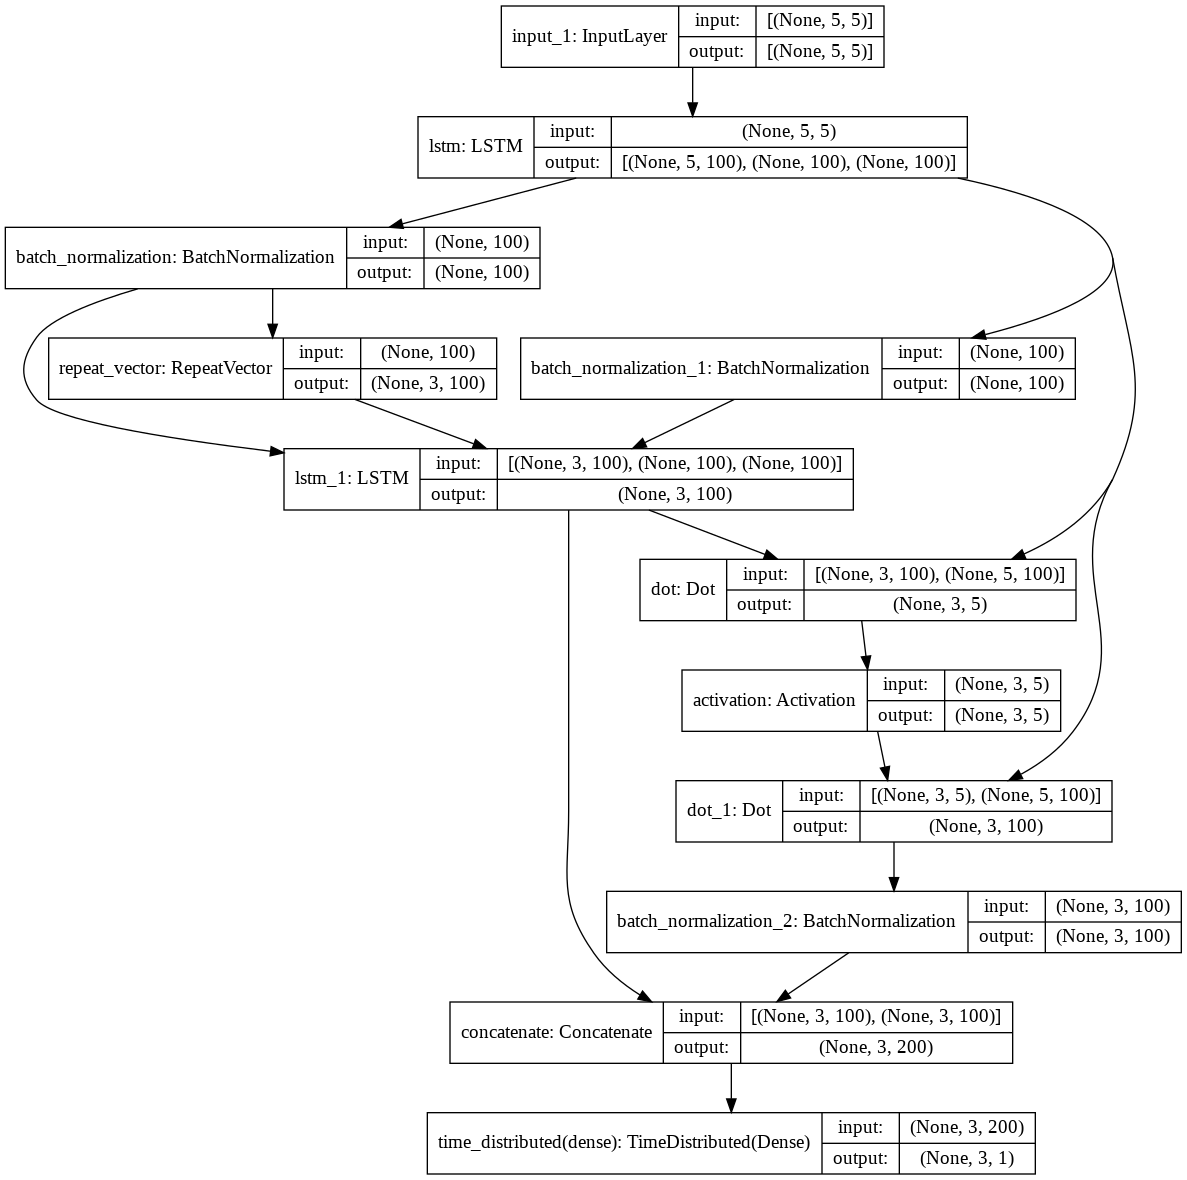

In [ ]:
plot_model(model, to_file='Attention_model_plot.png', show_shapes=True, show_layer_names=True)

***Training Phase ***

In [ ]:
epc = 500
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X1[:, :, :5], Y1[:, :, :1], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/500
32/32 [==============================] - 8s 59ms/step - loss: 10.4176 - mae: 2.2819 - val_loss: 0.1396 - val_mae: 0.3439
Epoch 2/500
32/32 [==============================] - 1s 37ms/step - loss: 0.5249 - mae: 0.5643 - val_loss: 0.2983 - val_mae: 0.4987
Epoch 3/500
32/32 [==============================] - 1s 37ms/step - loss: 0.2775 - mae: 0.4163 - val_loss: 0.2440 - val_mae: 0.4591
Epoch 4/500
32/32 [==============================] - 1s 37ms/step - loss: 0.2205 - mae: 0.3716 - val_loss: 0.0758 - val_mae: 0.1932
Epoch 5/500
32/32 [==============================] - 1s 36ms/step - loss: 0.3169 - mae: 0.4495 - val_loss: 0.2081 - val_mae: 0.4226
Epoch 6/500
32/32 [==============================] - 1s 38ms/step - loss: 0.1834 - mae: 0.3282 - val_loss: 0.1192 - val_mae: 0.3069
Epoch 7/500
32/32 [==============================] - 1s 38ms/step - loss: 0.1568 - mae: 0.3107 - val_loss: 0.1041 - val_mae: 0.2978
Epoch 8/500
32/32 [==============================] - 1s 41ms/step - loss: 0

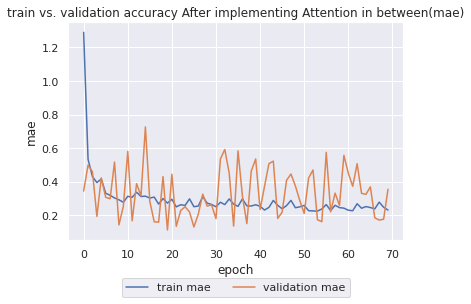

In [ ]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy After implementing Attention in between(mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

**Prediction phase**

In [ ]:
X_test


array([[[1.8905829 , 1.84083252, 1.95437271, 1.92634571, 1.87377436],
        [2.02567586, 1.94386692, 2.05511666, 2.00369465, 2.50633053],
        [1.98889662, 1.92711012, 2.03490568, 2.0169954 , 2.3346539 ],
        [2.01072166, 1.95025047, 2.07760785, 2.01464219, 1.86221314],
        [2.01536959, 1.93768286, 2.07304742, 2.00819644, 1.31368356]],

       [[2.02567586, 1.94386692, 2.05511666, 2.00369465, 2.50633053],
        [1.98889662, 1.92711012, 2.03490568, 2.0169954 , 2.3346539 ],
        [2.01072166, 1.95025047, 2.07760785, 2.01464219, 1.86221314],
        [2.01536959, 1.93768286, 2.07304742, 2.00819644, 1.31368356],
        [2.00203206, 1.92272143, 2.05283645, 1.9948957 , 1.74483293]],

       [[1.98889662, 1.92711012, 2.03490568, 2.0169954 , 2.3346539 ],
        [2.01072166, 1.95025047, 2.07760785, 2.01464219, 1.86221314],
        [2.01536959, 1.93768286, 2.07304742, 2.00819644, 1.31368356],
        [2.00203206, 1.92272143, 2.05283645, 1.9948957 , 1.74483293],
        [1.98212

In [ ]:
model = Model(inputs=input_train, outputs=out)
y_predicted=model.predict(X_test)

In [ ]:
# Y_actuals.shape

In [ ]:
y_predicted.shape
# print(y_predicted)

(996, 3, 1)

In [ ]:
y_predicted=y_predicted.reshape((996,3))

**Graph Visualization of predictions**

In [ ]:
predd=pd.DataFrame(y_predicted, columns=['1','2','3'])
predd

,1,2,3
0,1.700595,1.703955,1.716637
1,1.704570,1.707823,1.720817
2,1.693906,1.698044,1.711714
3,1.677366,1.683507,1.697771
4,1.664087,1.670877,1.685141
...,...,...,...
991,3.688644,3.662012,3.686068
992,3.680649,3.653841,3.677417
993,3.644877,3.618350,3.639438
994,3.541864,3.514269,3.521880


In [ ]:
predd=predd.drop([0])
predd=predd.reset_index(drop=True)
predd

,1,2,3
0,1.704570,1.707823,1.720817
1,1.693906,1.698044,1.711714
2,1.677366,1.683507,1.697771
3,1.664087,1.670877,1.685141
4,1.663000,1.668673,1.682436
...,...,...,...
990,3.688644,3.662012,3.686068
991,3.680649,3.653841,3.677417
992,3.644877,3.618350,3.639438
993,3.541864,3.514269,3.521880


In [ ]:
predd.to_csv('3_days_prediction_encoder_decoder using LOUNG attention.csv')

In [ ]:
Day1=predd['1'].values
Day2=predd['2'].values
Day3=predd['3'].values


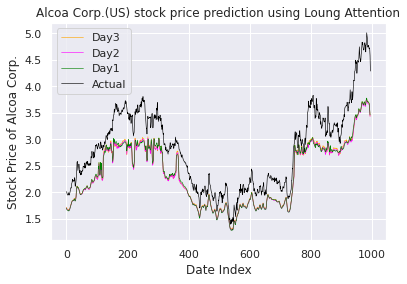

In [ ]:
plt.title('Alcoa Corp.(US) stock price prediction using Loung Attention')
plt.xlabel('Date Index')
plt.ylabel('Stock Price of Alcoa Corp.')

plt.plot(Day3, linewidth=0.6, color='orange')
plt.plot(Day2, linewidth=0.6, color='magenta')
plt.plot(Day1, linewidth=0.6, color='green')
plt.plot(Y_actuals, linewidth=0.6, color='black')
plt.legend(['Day3', 'Day2', 'Day1', 'Actual'], loc='upper left')
plt.savefig('three_days_prediction_using Encdec and Loung attention.png', dpi=1200)
#plt.legend()
plt.show()

### rmse and r2 score

In [ ]:
print(np.sqrt(np.mean(np.power((np.array(Y_actuals)-np.array(Day1)),2))))
print(np.sqrt(np.mean(np.power((np.array(Y_actuals)-np.array(Day2)),2))))
print(np.sqrt(np.mean(np.power((np.array(Y_actuals)-np.array(Day3)),2))))



1.0699307800684767
1.069945353696946
1.065061970663352


In [ ]:
 Y=Y_actuals.iloc[:995,:]
 

In [ ]:
print(r2_score(Y, Day1))
print(r2_score(Y, Day2))
print(r2_score(Y, Day3))


0.5545913457886169
0.5334557071176745
0.5543688475762548
